# 🚦 Hypertuning params – LISA Traffic Light Patches  
**Mục tiêu (nhẹ, đúng vai trò tập):**  
- Chia **TRAIN/TEST** (hold-out TEST chỉ chấm 1 lần cuối).  
- **A/B:** Ablate **HOG params** (cell, block, orientations) với **classifier cố định** (RBF-SVM mặc định) → chọn **best HOG** theo **CV macro-F1 trên TRAIN**.  
- **C:** Chọn classifier **Linear SVM vs RBF SVM vs SGD(log_loss)** với **tune rất nhẹ** (mỗi model 2–4 giá trị) bằng **CV trên TRAIN**.  
- Train final model trên **full TRAIN** và evaluate **ONCE** trên **TEST**.  


In [1]:
# =========================
# 0) Imports & Setup
# =========================
import os, json, random
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from skimage.feature import hog
from skimage.color import rgb2gray

import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- your repo helpers ---
from dataset_lisa import build_patch_dataset_from_box_csvs
from features_hog import hog_batch  # baseline HOG in your repo

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception:
        pass

print("TF:", tf.__version__)

TF: 2.20.0


In [2]:
# =========================
# 1) Config
# =========================
DATASET_ROOT = r"C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2"  # TODO: change if needed
RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_SAMPLES = 20000

LABEL_MAP = {0: "other", 1: "green", 2: "red", 3: "yellow"}
LABELS = [0, 1, 2, 3]
TARGET_NAMES = [LABEL_MAP[i] for i in LABELS]

os.makedirs("outputs", exist_ok=True)
seed_everything(RANDOM_SEED)

Building dataset from LISA annotations...
Patches: (20000, 64, 64, 3) Labels: (20000,)
0 other : 9670
1 green : 5871
2 red : 4167
3 yellow : 292


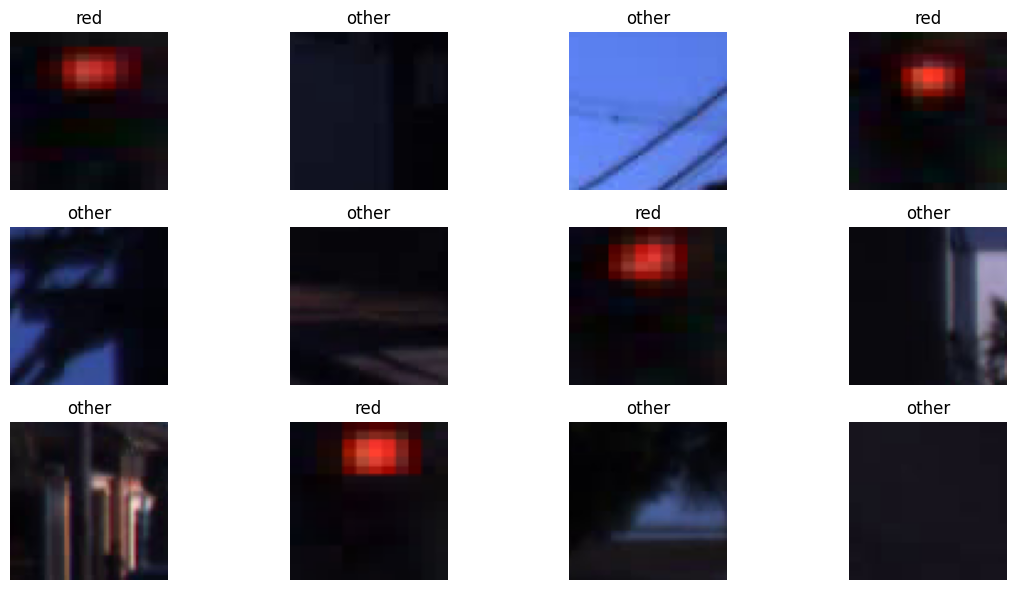

In [3]:
# =========================
# 2) Load patch dataset (try to match your main pipeline)
# =========================
print("Building dataset from LISA annotations...")

try:
    X_patches, y = build_patch_dataset_from_box_csvs(
        dataset_root=DATASET_ROOT,
        max_samples=MAX_SAMPLES,
        add_other=True,
        n_other_per_image=2,
        other_max_iou=0.02,
        seed=RANDOM_SEED
    )
except TypeError:
    # fallback (if your loader has different signature)
    X_patches, y = build_patch_dataset_from_box_csvs(DATASET_ROOT, max_samples=MAX_SAMPLES)

X_patches = np.asarray(X_patches)
y = np.asarray(y).astype(int)

print("Patches:", X_patches.shape, "Labels:", y.shape)
u, c = np.unique(y, return_counts=True)
for ui, ci in zip(u, c):
    print(int(ui), LABEL_MAP.get(int(ui), str(ui)), ":", int(ci))

# quick visualize
nshow = min(12, len(X_patches))
plt.figure(figsize=(12, 6))
for i in range(nshow):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_patches[i])
    plt.title(LABEL_MAP[int(y[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# =========================
# 3) Train/Test split (hold-out TEST)
# =========================
X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_patches, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)
print("Train patches:", X_train_p.shape, "Test patches:", X_test_p.shape)

Train patches: (16000, 64, 64, 3) Test patches: (4000, 64, 64, 3)


In [5]:
# =========================
# 4) Feature extractors
# =========================
def hog_batch_param(X_patches_uint8, cell=4, block=2, orientations=6):
    feats = []
    for img in X_patches_uint8:
        gray = rgb2gray(img)  # float [0..1]
        f = hog(
            gray,
            orientations=int(orientations),
            pixels_per_cell=(int(cell), int(cell)),
            cells_per_block=(int(block), int(block)),
            block_norm="L2-Hys",
            feature_vector=True
        )
        feats.append(f.astype(np.float32))
    return np.vstack(feats).astype(np.float32)

def build_vgg16_feature_extractor():
    base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
    return tf.keras.Sequential([base, tf.keras.layers.GlobalAveragePooling2D()])

def vgg16_features(model, X_uint8, batch_size=64):
    X = X_uint8.astype(np.float32)
    X = preprocess_input(X)
    feats = model.predict(X, batch_size=batch_size, verbose=1)
    return feats.astype(np.float32)

def make_rbf_svm(C=1.0, gamma="scale", class_weight=None):
    return make_pipeline(StandardScaler(), SVC(C=C, kernel="rbf", gamma=gamma, class_weight=class_weight))

def make_linear_svm(C=1.0, class_weight=None):
    # LinearSVC không cần StandardScaler bắt buộc, nhưng giữ để nhất quán
    return make_pipeline(StandardScaler(), LinearSVC(C=C, class_weight=class_weight))

def make_sgd_logloss(lr=1e-4, seed=RANDOM_SEED, class_weight=None):
    # class_weight cho SGDClassifier: dùng sample_weight (phức tạp hơn). Mình giữ đơn giản.
    return make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss="log_loss",
            learning_rate="constant",
            eta0=lr,
            max_iter=2000,
            tol=1e-3,
            random_state=seed
        )
    )

def cv_score(estimator, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    scoring = {"acc": "accuracy", "f1_macro": "f1_macro"}
    res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        "acc_mean": float(res["test_acc"].mean()),
        "acc_std":  float(res["test_acc"].std()),
        "f1_mean":  float(res["test_f1_macro"].mean()),
        "f1_std":   float(res["test_f1_macro"].std()),
    }

In [6]:
# =========================
# 5) Base features (HOG baseline + VGG16 freeze) on TRAIN/TEST
# =========================
# HOG baseline from your repo
X_train_hog_base = hog_batch(X_train_p)
X_test_hog_base  = hog_batch(X_test_p)
print("HOG(base) train:", X_train_hog_base.shape, "test:", X_test_hog_base.shape)

print("Loading VGG16 feature extractor (freeze)...")
vgg_feat_model = build_vgg16_feature_extractor()
X_train_vgg = vgg16_features(vgg_feat_model, X_train_p, batch_size=64)
X_test_vgg  = vgg16_features(vgg_feat_model, X_test_p, batch_size=64)
print("VGG16(freeze) train:", X_train_vgg.shape, "test:", X_test_vgg.shape)

HOG(base) train: (16000, 900) test: (4000, 900)
Loading VGG16 feature extractor (freeze)...
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 380ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step
VGG16(freeze) train: (16000, 512) test: (4000, 512)


## A/B) Ablation HOG params (NHẸ)  
- **Không tune SVM grid** ở đây.  
- Chỉ đổi HOG params → chấm bằng **CV trên TRAIN** với **RBF-SVM cố định**.

In [7]:
# =========================
# 6) Ablation A/B: HOG params only (CV on TRAIN ONLY)
# =========================
hog_grid = [
    # (cell, block, orientations) - chọn ít cho nhẹ
    (4, 2, 6),   # gần baseline
    (4, 2, 9),
    (6, 2, 6),
    (8, 2, 6),
    (10, 2, 9),  # bạn từng thấy ổn
]

# fixed classifier for HOG ablation
FIXED_RBF = dict(C=1.0, gamma="scale", class_weight=None)

results_hog = []
best_hog = None

print("=== CV ABLATION (HOG params only) on TRAIN ===")
print("Fixed RBF-SVM:", FIXED_RBF)

for (cell, block, ori) in hog_grid:
    print(f"  Extract HOG: cell={cell}, block={block}, ori={ori}")
    Xtr_feat = hog_batch_param(X_train_p, cell=cell, block=block, orientations=ori)
    dim = int(Xtr_feat.shape[1])
    est = make_rbf_svm(**FIXED_RBF)
    sc = cv_score(est, Xtr_feat, y_train)
    row = {
        "cell": int(cell), "block": int(block), "ori": int(ori), "dim": dim,
        **sc
    }
    results_hog.append(row)
    if (best_hog is None) or (row["f1_mean"] > best_hog["f1_mean"]):
        best_hog = row
        print("    -> NEW BEST:", {k: best_hog[k] for k in ["cell","block","ori","f1_mean","acc_mean"]})

print("\n=== BEST HOG (by CV macro-F1 on TRAIN) ===")
print(best_hog)

# Prepare best-HOG features for later classifier selection
X_train_hog_best = hog_batch_param(X_train_p, cell=best_hog["cell"], block=best_hog["block"], orientations=best_hog["ori"])
X_test_hog_best  = hog_batch_param(X_test_p,  cell=best_hog["cell"], block=best_hog["block"], orientations=best_hog["ori"])
print("Best-HOG train:", X_train_hog_best.shape, "test:", X_test_hog_best.shape)

=== CV ABLATION (HOG params only) on TRAIN ===
Fixed RBF-SVM: {'C': 1.0, 'gamma': 'scale', 'class_weight': None}
  Extract HOG: cell=4, block=2, ori=6
    -> NEW BEST: {'cell': 4, 'block': 2, 'ori': 6, 'f1_mean': 0.9882932942040084, 'acc_mean': 0.99125}
  Extract HOG: cell=4, block=2, ori=9
    -> NEW BEST: {'cell': 4, 'block': 2, 'ori': 9, 'f1_mean': 0.9888380725776148, 'acc_mean': 0.9913124999999999}
  Extract HOG: cell=6, block=2, ori=6
    -> NEW BEST: {'cell': 6, 'block': 2, 'ori': 6, 'f1_mean': 0.9912379209063105, 'acc_mean': 0.9921875}
  Extract HOG: cell=8, block=2, ori=6
    -> NEW BEST: {'cell': 8, 'block': 2, 'ori': 6, 'f1_mean': 0.9919254233475063, 'acc_mean': 0.9923125}
  Extract HOG: cell=10, block=2, ori=9

=== BEST HOG (by CV macro-F1 on TRAIN) ===
{'cell': 8, 'block': 2, 'ori': 6, 'dim': 1176, 'acc_mean': 0.9923125, 'acc_std': 0.001259340104975613, 'f1_mean': 0.9919254233475063, 'f1_std': 0.0017240107660160175}
Best-HOG train: (16000, 1176) test: (4000, 1176)


## C) Chọn classifier (Linear / RBF / SGD) + tune rất nhẹ  
- Chỉ tune nhẹ:  
  - LinearSVM: `C` ∈ {0.5, 1.0, 2.0}  
  - RBF-SVM: `C` ∈ {0.5, 1.0, 2.0} (gamma giữ `scale`)  
  - SGD(log_loss): `lr` ∈ {1e-4, 5e-4}  
- Đánh giá bằng **CV trên TRAIN** → chọn best theo **macro-F1**.  
- Làm riêng cho: **Best-HOG** và **VGG16(freeze)**.

In [8]:
# =========================
# 7) LIGHT classifier selection with tiny hyperparam grids (CV on TRAIN)
# =========================
C_grid = [0.5, 1.0, 2.0]
lr_grid = [1e-4, 5e-4]  # tiny

def select_best_classifier(Xtr, ytr, feat_name):
    trials = []

    # Linear SVM
    for C in C_grid:
        est = make_linear_svm(C=C)
        sc = cv_score(est, Xtr, ytr)
        trials.append({"feat": feat_name, "clf": "LinearSVM", "C": C, "gamma": None, "lr": None, **sc})

    # RBF SVM (gamma fixed)
    for C in C_grid:
        est = make_rbf_svm(C=C, gamma="scale")
        sc = cv_score(est, Xtr, ytr)
        trials.append({"feat": feat_name, "clf": "RBFSVM", "C": C, "gamma": "scale", "lr": None, **sc})

    # SGD log_loss
    for lr in lr_grid:
        est = make_sgd_logloss(lr=lr)
        sc = cv_score(est, Xtr, ytr)
        trials.append({"feat": feat_name, "clf": "SGD_logloss", "C": None, "gamma": None, "lr": lr, **sc})

    best = max(trials, key=lambda d: d["f1_mean"])
    print(f"\n=== BEST CLASSIFIER for {feat_name} (by CV macro-F1 on TRAIN) ===")
    print(best)

    # show top-5 quick
    print("\nTop-5 trials:")
    for i, t in enumerate(sorted(trials, key=lambda d: d["f1_mean"], reverse=True)[:5], 1):
        print(f"{i:02d} | {t['clf']:>11} | C={t['C']} lr={t['lr']} | F1={t['f1_mean']:.4f}±{t['f1_std']:.4f} | ACC={t['acc_mean']:.4f}±{t['acc_std']:.4f}")

    return best, trials

best_clf_hog, trials_hog = select_best_classifier(X_train_hog_best, y_train, "HOG(best)")
best_clf_vgg, trials_vgg = select_best_classifier(X_train_vgg, y_train, "VGG16(freeze)")


=== BEST CLASSIFIER for HOG(best) (by CV macro-F1 on TRAIN) ===
{'feat': 'HOG(best)', 'clf': 'RBFSVM', 'C': 2.0, 'gamma': 'scale', 'lr': None, 'acc_mean': 0.9931249999999998, 'acc_std': 0.001218349293101106, 'f1_mean': 0.9925703453261712, 'f1_std': 0.001656161579539878}

Top-5 trials:
01 |      RBFSVM | C=2.0 lr=None | F1=0.9926±0.0017 | ACC=0.9931±0.0012
02 |      RBFSVM | C=1.0 lr=None | F1=0.9919±0.0017 | ACC=0.9923±0.0013
03 |      RBFSVM | C=0.5 lr=None | F1=0.9899±0.0020 | ACC=0.9911±0.0014
04 | SGD_logloss | C=None lr=0.0005 | F1=0.9823±0.0032 | ACC=0.9843±0.0003
05 | SGD_logloss | C=None lr=0.0001 | F1=0.9809±0.0037 | ACC=0.9828±0.0009

=== BEST CLASSIFIER for VGG16(freeze) (by CV macro-F1 on TRAIN) ===
{'feat': 'VGG16(freeze)', 'clf': 'RBFSVM', 'C': 2.0, 'gamma': 'scale', 'lr': None, 'acc_mean': 0.9936875000000001, 'acc_std': 0.0017940875118009204, 'f1_mean': 0.9903550822605303, 'f1_std': 0.0023461752866696683}

Top-5 trials:
01 |      RBFSVM | C=2.0 lr=None | F1=0.9904±0.002

## Final: chọn feature family + classifier theo CV, rồi chấm TEST 1 lần  
- So sánh best(HOG) vs best(VGG) dựa trên **CV macro-F1**.  
- Fit model cuối trên full TRAIN, chấm trên TEST.  


In [9]:
# =========================
# 8) Choose overall best (HOG(best) vs VGG) by CV macro-F1, then final TEST once
# =========================
best_overall = best_clf_hog if best_clf_hog["f1_mean"] >= best_clf_vgg["f1_mean"] else best_clf_vgg
print("\n=== BEST OVERALL (by CV macro-F1 on TRAIN) ===")
print(best_overall)

def build_est_from_cfg(cfg):
    if cfg["clf"] == "LinearSVM":
        return make_linear_svm(C=float(cfg["C"]))
    if cfg["clf"] == "RBFSVM":
        return make_rbf_svm(C=float(cfg["C"]), gamma="scale")
    if cfg["clf"] == "SGD_logloss":
        return make_sgd_logloss(lr=float(cfg["lr"]))
    raise ValueError("Unknown clf")

# pick correct features
if best_overall["feat"] == "HOG(best)":
    Xtr_final, Xte_final = X_train_hog_best, X_test_hog_best
else:
    Xtr_final, Xte_final = X_train_vgg, X_test_vgg

final_model = build_est_from_cfg(best_overall)
final_model.fit(Xtr_final, y_train)
y_pred = final_model.predict(Xte_final)

test_acc = accuracy_score(y_test, y_pred)
test_f1  = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred, labels=LABELS)

print("\n================ FINAL TEST (HOLD-OUT) ================")
print("Chosen:", best_overall)
print("TEST Accuracy:", test_acc)
print("TEST Macro-F1:", test_f1)
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred, labels=LABELS, target_names=TARGET_NAMES, zero_division=0))


=== BEST OVERALL (by CV macro-F1 on TRAIN) ===
{'feat': 'HOG(best)', 'clf': 'RBFSVM', 'C': 2.0, 'gamma': 'scale', 'lr': None, 'acc_mean': 0.9931249999999998, 'acc_std': 0.001218349293101106, 'f1_mean': 0.9925703453261712, 'f1_std': 0.001656161579539878}

================ FINAL TEST (HOLD-OUT) ================
Chosen: {'feat': 'HOG(best)', 'clf': 'RBFSVM', 'C': 2.0, 'gamma': 'scale', 'lr': None, 'acc_mean': 0.9931249999999998, 'acc_std': 0.001218349293101106, 'f1_mean': 0.9925703453261712, 'f1_std': 0.001656161579539878}
TEST Accuracy: 0.99625
TEST Macro-F1: 0.9950185378646712
Confusion matrix:
 [[1932    1    1    0]
 [   6 1167    1    0]
 [   5    0  829    0]
 [   1    0    0   57]]
              precision    recall  f1-score   support

       other       0.99      1.00      1.00      1934
       green       1.00      0.99      1.00      1174
         red       1.00      0.99      1.00       834
      yellow       1.00      0.98      0.99        58

    accuracy                    

In [10]:
# =========================
# 9) Save outputs
# =========================
payload = {
    "best_hog_params": best_hog,
    "fixed_rbf_for_hog_ablation": {"C": 1.0, "gamma": "scale", "class_weight": None},
    "best_clf_hog": best_clf_hog,
    "best_clf_vgg": best_clf_vgg,
    "best_overall_cv": best_overall,
    "final_test": {"acc": float(test_acc), "macro_f1": float(test_f1), "cm": cm.tolist()},
    "note": "HOG ablation uses fixed RBF-SVM; classifier selection uses tiny grids; TEST used once at end."
}

with open("outputs/ablation_light_best_config.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

joblib.dump(final_model, "outputs/ablation_light_best_model.joblib")

print("Saved: outputs/ablation_light_best_config.json")
print("Saved: outputs/ablation_light_best_model.joblib")

Saved: outputs/ablation_light_best_config.json
Saved: outputs/ablation_light_best_model.joblib
